In [31]:
from pymongo import MongoClient
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Conexión a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]

# Cargar datos desde MongoDB
def load_data():
    # Obtener datos desde MongoDB
    customers = pd.DataFrame(list(db["customers"].find({}, {"Customer ID": 1, "First Name": 1, "_id": 0})))
    products = pd.DataFrame(list(db["products"].find({}, {"Product ID": 1, "General Category ID": 1, "_id": 0})))
    orders = pd.DataFrame(list(db["orders"].find({}, {"Customer ID": 1, "Product ID": 1, "_id": 0})))
    categories = pd.DataFrame(list(db["categories"].find({}, {"Category ID": 1, "Name": 1, "_id": 0})))
    
    # Validar que las columnas existan
    print("Estructura de los datos cargados:")
    print("Clientes:", customers.columns.tolist())
    print("Productos:", products.columns.tolist())
    print("Órdenes:", orders.columns.tolist())
    print("Categorías:", categories.columns.tolist())
    
    return customers, products, orders, categories

# Crear una matriz de interacciones usuario-categoría general
def create_interaction_matrix(customers, products, orders, categories):
    # Fusionar datos para obtener las categorías generales en las órdenes
    orders = orders.merge(products, on="Product ID", how="left")  # Agregar General Category ID a las órdenes
    orders = orders.merge(categories, left_on="General Category ID", right_on="Category ID", how="left")  # Agregar nombre de la categoría
    
    if "General Category ID" not in orders.columns:
        raise ValueError("La columna 'General Category ID' no se encontró después de fusionar datos.")
    
    # Crear una matriz de interacciones usuario-categoría general
    interaction_matrix = orders.groupby(["Customer ID", "General Category ID"]).size().unstack(fill_value=0)
    
    print("\nMatriz de interacción creada (Usuario - Categoría General):")
    print(interaction_matrix.head())
    return interaction_matrix, orders

# Entrenar un modelo de recomendación basado en categorías generales
def train_model(interaction_matrix):
    # Convertir la matriz a formato disperso
    sparse_matrix = csr_matrix(interaction_matrix)
    
    # Calcular similitud entre usuarios
    user_similarity = cosine_similarity(sparse_matrix)
    
    # Crear un DataFrame para la similitud
    similarity_df = pd.DataFrame(user_similarity, index=interaction_matrix.index, columns=interaction_matrix.index)
    return similarity_df

# Generar recomendaciones para un usuario
def recommend_products(user_id, interaction_matrix, similarity_df, orders, categories, top_n=5):
    # Verificar si el usuario tiene categorías generales en la matriz
    if user_id not in interaction_matrix.index:
        print(f"Usuario {user_id} no tiene datos suficientes para recomendaciones.")
        return pd.DataFrame(columns=["Producto", "Categoría General", "Relevancia"])
    
    # Obtener las categorías generales compradas por el usuario
    user_categories = interaction_matrix.loc[user_id]
    user_categories = user_categories[user_categories > 0].index.tolist()  # Categorías relevantes del usuario
    
    # Filtrar usuarios similares al actual
    similar_users = similarity_df[user_id].sort_values(ascending=False).index.tolist()
    similar_users.remove(user_id)  # Excluir al usuario actual
    
    # Filtrar órdenes de usuarios similares en las categorías generales del usuario actual
    similar_orders = orders[orders["Customer ID"].isin(similar_users)]
    similar_orders = similar_orders[similar_orders["General Category ID"].isin(user_categories)]
    
    # Contar productos más comprados por usuarios similares en las categorías generales relevantes
    product_counts = similar_orders["Product ID"].value_counts().head(top_n)
    
    # Mapear productos a nombres de categorías generales
    product_details = pd.DataFrame(product_counts).reset_index()
    product_details.columns = ["Product ID", "Relevancia"]
    product_details = product_details.merge(categories, left_on="Product ID", right_on="Category ID", how="left")
    
    return product_details[["Product ID", "Name", "Relevancia"]]

# Flujo principal
def main():
    # Cargar datos
    customers, products, orders, categories = load_data()
    
    # Crear matriz de interacciones
    interaction_matrix, enriched_orders = create_interaction_matrix(customers, products, orders, categories)
    
    # Entrenar modelo
    similarity_df = train_model(interaction_matrix)
    
    # Seleccionar un usuario para recomendar
    user_id = interaction_matrix.index[0]  # Selecciona el primer usuario (puedes cambiarlo)
    recommendations = recommend_products(user_id, interaction_matrix, similarity_df, enriched_orders, categories)
    
    # Mostrar recomendaciones
    print(f"\nRecomendaciones para el usuario {user_id}:\n", recommendations)

# Ejecutar flujo principal
if __name__ == "__main__":
    main()


Estructura de los datos cargados:
Clientes: ['Customer ID', 'First Name']
Productos: ['Product ID', 'General Category ID']
Órdenes: ['Customer ID', 'Product ID']
Categorías: ['Category ID', 'Name']

Matriz de interacción creada (Usuario - Categoría General):
General Category ID                   5507398f-953c-4b53-82b7-821c7d517b07  \
Customer ID                                                                  
045910da-43bf-4250-8315-8b740ffb847e                                     0   
06ace6a5-52f2-4277-a4cd-d30580835089                                     0   
07689019-ae2f-41e5-96eb-b4d76fe56d19                                     0   
0b46eb6f-01a5-4fd2-9268-fd429ca50121                                     0   
0e1688bc-1291-45d3-bc55-76ed9261d218                                     0   

General Category ID                   8deb576c-7d41-4b80-8667-5f2300ceb4c6  \
Customer ID                                                                  
045910da-43bf-4250-8315-8b740ffb847e  

In [32]:
from pymongo import MongoClient
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Conexión a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]

# Cargar datos desde MongoDB
def load_data():
    customers = pd.DataFrame(list(db["customers"].find({}, {"Customer ID": 1, "First Name": 1, "_id": 0})))
    products = pd.DataFrame(list(db["products"].find({}, {"Product ID": 1, "General Category ID": 1, "_id": 0})))
    orders = pd.DataFrame(list(db["orders"].find({}, {"Customer ID": 1, "Product ID": 1, "_id": 0})))
    categories = pd.DataFrame(list(db["categories"].find({}, {"Category ID": 1, "Name": 1, "_id": 0})))
    
    print("Estructura de los datos cargados:")
    print("Clientes:", customers.columns.tolist())
    print("Productos:", products.columns.tolist())
    print("Órdenes:", orders.columns.tolist())
    print("Categorías:", categories.columns.tolist())
    
    return customers, products, orders, categories

# Crear matriz de interacciones usuario-categoría general
def create_interaction_matrix(customers, products, orders, categories):
    orders = orders.merge(products, on="Product ID", how="left")
    orders = orders.merge(categories, left_on="General Category ID", right_on="Category ID", how="left")
    
    if "General Category ID" not in orders.columns:
        raise ValueError("La columna 'General Category ID' no se encontró después de fusionar datos.")
    
    interaction_matrix = orders.groupby(["Customer ID", "General Category ID"]).size().unstack(fill_value=0)
    
    print("\nMatriz de interacción creada (Usuario - Categoría General):")
    print(interaction_matrix.head())
    return interaction_matrix, orders

# Entrenar un modelo de recomendación basado en categorías generales
def train_model(interaction_matrix):
    sparse_matrix = csr_matrix(interaction_matrix)
    user_similarity = cosine_similarity(sparse_matrix)
    similarity_df = pd.DataFrame(user_similarity, index=interaction_matrix.index, columns=interaction_matrix.index)
    return similarity_df

# Generar recomendaciones para un usuario
def recommend_products(user_id, interaction_matrix, similarity_df, orders, categories, top_n=5):
    if user_id not in interaction_matrix.index:
        print(f"Usuario {user_id} no tiene datos suficientes para recomendaciones.")
        return pd.DataFrame(columns=["Product ID", "Relevancia"])
    
    user_categories = interaction_matrix.loc[user_id]
    user_categories = user_categories[user_categories > 0].index.tolist()
    
    similar_users = similarity_df[user_id].sort_values(ascending=False).index.tolist()
    similar_users.remove(user_id)
    
    similar_orders = orders[orders["Customer ID"].isin(similar_users)]
    similar_orders = similar_orders[similar_orders["General Category ID"].isin(user_categories)]
    
    product_counts = similar_orders["Product ID"].value_counts().head(top_n)
    
    recommended_products = pd.DataFrame({
        "Product ID": product_counts.index,
        "Relevancia": product_counts.values
    })
    
    return recommended_products

# Flujo principal
def main():
    # Cargar datos
    customers, products, orders, categories = load_data()
    
    # Crear matriz de interacciones
    interaction_matrix, enriched_orders = create_interaction_matrix(customers, products, orders, categories)
    
    # Entrenar modelo
    similarity_df = train_model(interaction_matrix)
    
    # Seleccionar un usuario para recomendar
    user_id = interaction_matrix.index[0]
    recommendations = recommend_products(user_id, interaction_matrix, similarity_df, enriched_orders, categories)
    
    # Mostrar los IDs de los productos más relevantes
    print(f"\nIDs de los {len(recommendations)} productos más relevantes para el usuario {user_id}:")
    print(recommendations)

# Ejecutar flujo principal
if __name__ == "__main__":
    main()


Estructura de los datos cargados:
Clientes: ['Customer ID', 'First Name']
Productos: ['Product ID', 'General Category ID']
Órdenes: ['Customer ID', 'Product ID']
Categorías: ['Category ID', 'Name']

Matriz de interacción creada (Usuario - Categoría General):
General Category ID                   5507398f-953c-4b53-82b7-821c7d517b07  \
Customer ID                                                                  
045910da-43bf-4250-8315-8b740ffb847e                                     0   
06ace6a5-52f2-4277-a4cd-d30580835089                                     0   
07689019-ae2f-41e5-96eb-b4d76fe56d19                                     0   
0b46eb6f-01a5-4fd2-9268-fd429ca50121                                     0   
0e1688bc-1291-45d3-bc55-76ed9261d218                                     0   

General Category ID                   8deb576c-7d41-4b80-8667-5f2300ceb4c6  \
Customer ID                                                                  
045910da-43bf-4250-8315-8b740ffb847e  


Recomendaciones para el usuario 1c532533-b8bb-4ac6-8f89-1b3b3bf0f8e2:
                              Product ID  Relevancia
0  83ffbafe-7486-4a9a-8f27-c11a1b3a8eb0           6
1  e3238512-01f0-42bc-9d3f-f3774341b96c           4
2  6dd9eb54-65bc-4852-acd5-bb0dc7465d95           3
3  3dcc1440-cc23-4925-b0d6-367168439165           3
4  a36ed1f4-5a00-4d8d-9758-60ff92050dd6           3


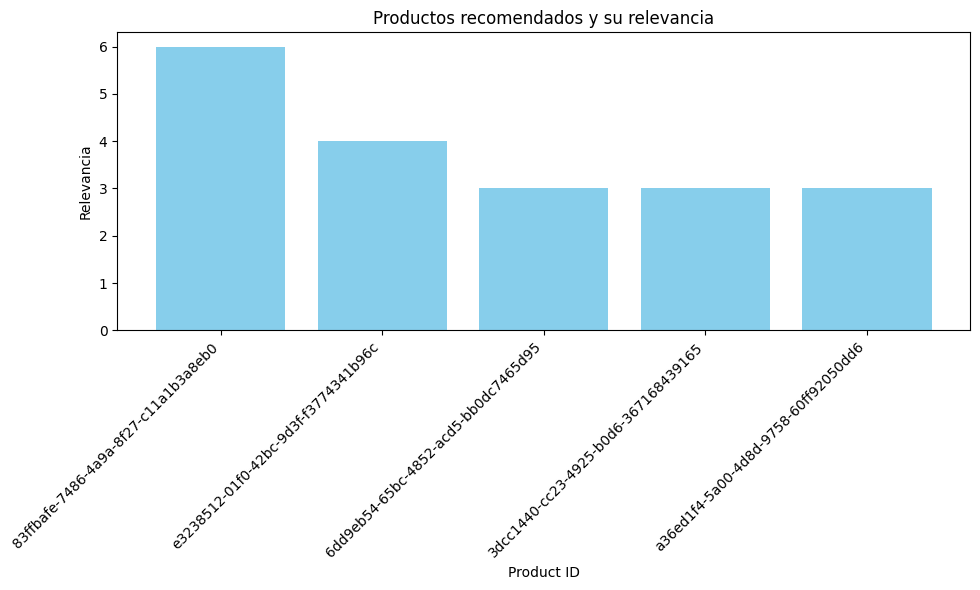

In [33]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Conexión a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]

# Cargar datos desde MongoDB
def load_data():
    customers = pd.DataFrame(list(db["customers"].find({}, {"Customer ID": 1, "First Name": 1, "_id": 0})))
    products = pd.DataFrame(list(db["products"].find({}, {"Product ID": 1, "General Category ID": 1, "_id": 0})))
    orders = pd.DataFrame(list(db["orders"].find({}, {"Customer ID": 1, "Product ID": 1, "_id": 0})))
    categories = pd.DataFrame(list(db["categories"].find({}, {"Category ID": 1, "Name": 1, "_id": 0})))
    
    return customers, products, orders, categories

# Crear matriz de interacciones usuario-categoría general
def create_interaction_matrix(customers, products, orders, categories):
    orders = orders.merge(products, on="Product ID", how="left")
    orders = orders.merge(categories, left_on="General Category ID", right_on="Category ID", how="left")
    
    interaction_matrix = orders.groupby(["Customer ID", "General Category ID"]).size().unstack(fill_value=0)
    return interaction_matrix, orders

# Entrenar un modelo de recomendación basado en categorías generales
def train_model(interaction_matrix):
    sparse_matrix = csr_matrix(interaction_matrix)
    user_similarity = cosine_similarity(sparse_matrix)
    similarity_df = pd.DataFrame(user_similarity, index=interaction_matrix.index, columns=interaction_matrix.index)
    return similarity_df

# Generar recomendaciones para un usuario
def recommend_products(user_id, interaction_matrix, similarity_df, orders, categories, top_n=5):
    if user_id not in interaction_matrix.index:
        print(f"Usuario {user_id} no tiene datos suficientes para recomendaciones.")
        return pd.DataFrame(columns=["Product ID", "Relevancia"])
    
    user_categories = interaction_matrix.loc[user_id]
    user_categories = user_categories[user_categories > 0].index.tolist()
    
    similar_users = similarity_df[user_id].sort_values(ascending=False).index.tolist()
    similar_users.remove(user_id)
    
    similar_orders = orders[orders["Customer ID"].isin(similar_users)]
    similar_orders = similar_orders[similar_orders["General Category ID"].isin(user_categories)]
    
    product_counts = similar_orders["Product ID"].value_counts().head(top_n)
    
    recommended_products = pd.DataFrame({
        "Product ID": product_counts.index,
        "Relevancia": product_counts.values
    })
    
    return recommended_products

# Graficar recomendaciones
def plot_recommendations(recommended_products):
    plt.figure(figsize=(10, 6))
    plt.bar(recommended_products["Product ID"], recommended_products["Relevancia"], color='skyblue')
    plt.title("Productos recomendados y su relevancia")
    plt.xlabel("Product ID")
    plt.ylabel("Relevancia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Flujo principal
def main():
    customers, products, orders, categories = load_data()
    interaction_matrix, enriched_orders = create_interaction_matrix(customers, products, orders, categories)
    similarity_df = train_model(interaction_matrix)
    
    user_id = interaction_matrix.index[10]
    recommendations = recommend_products(user_id, interaction_matrix, similarity_df, enriched_orders, categories)
    
    print(f"\nRecomendaciones para el usuario {user_id}:\n", recommendations)
    
    # Graficar las recomendaciones
    if not recommendations.empty:
        plot_recommendations(recommendations)

# Ejecutar flujo principal
if __name__ == "__main__":
    main()



Recomendaciones para el usuario 045910da-43bf-4250-8315-8b740ffb847e:
                              Product ID  Relevancia
0  83ffbafe-7486-4a9a-8f27-c11a1b3a8eb0           6
1  e3238512-01f0-42bc-9d3f-f3774341b96c           4
2  6dd9eb54-65bc-4852-acd5-bb0dc7465d95           3
3  779557d2-bace-4cc8-852f-c38d381e445b           3
4  a36ed1f4-5a00-4d8d-9758-60ff92050dd6           3

Evaluación del modelo:
Precisión: 0.0000
Recall: 0.0000
F1: 0.0000


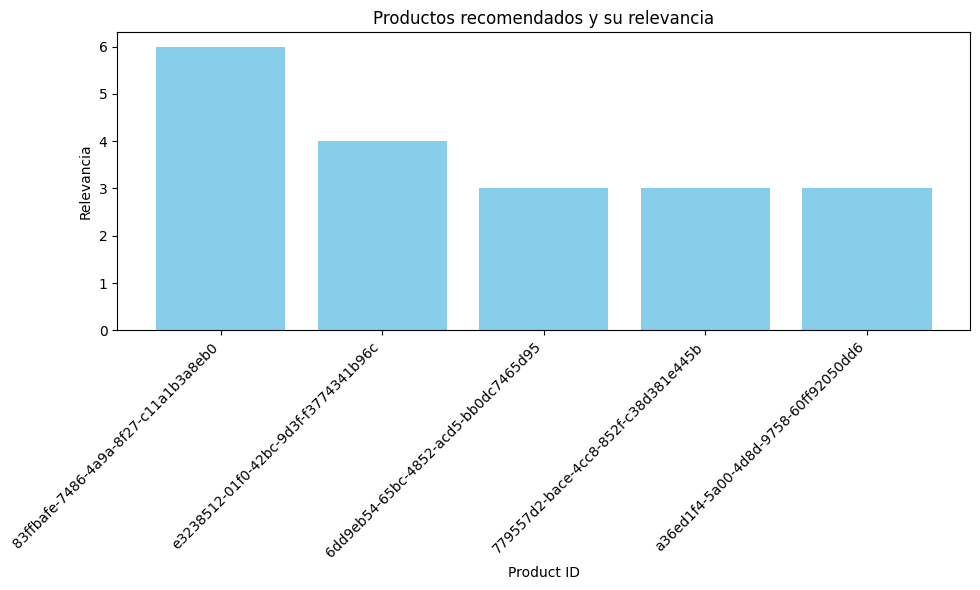

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Evaluar el modelo de recomendación
def evaluate_model(interaction_matrix, similarity_df, orders, top_n=5):
    """
    Evalúa el modelo de recomendación usando métricas de precisión, recall y F1.
    
    Args:
        interaction_matrix (pd.DataFrame): Matriz de interacciones usuario-categoría.
        similarity_df (pd.DataFrame): Matriz de similitud usuario-usuario.
        orders (pd.DataFrame): Datos de órdenes enriquecidos.
        top_n (int): Número de recomendaciones a evaluar.
    
    Returns:
        dict: Métricas de evaluación (Precisión, Recall, F1).
    """
    y_true = []
    y_pred = []
    
    for user_id in interaction_matrix.index:
        # Obtener categorías compradas por el usuario
        user_categories = interaction_matrix.loc[user_id]
        user_categories = user_categories[user_categories > 0].index.tolist()
        
        if not user_categories:
            continue  # Saltar si el usuario no tiene interacciones
        
        # Obtener usuarios similares
        similar_users = similarity_df[user_id].sort_values(ascending=False).index.tolist()
        similar_users.remove(user_id)
        
        # Obtener órdenes relevantes de usuarios similares
        similar_orders = orders[orders["Customer ID"].isin(similar_users)]
        similar_orders = similar_orders[similar_orders["General Category ID"].isin(user_categories)]
        
        # Productos relevantes (verdaderos)
        relevant_products = set(orders[orders["Customer ID"] == user_id]["Product ID"])
        y_true.extend([1 if prod in relevant_products else 0 for prod in interaction_matrix.columns])
        
        # Productos recomendados
        recommended_products = similar_orders["Product ID"].value_counts().head(top_n).index.tolist()
        y_pred.extend([1 if prod in recommended_products else 0 for prod in interaction_matrix.columns])
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return {"Precision": precision, "Recall": recall, "F1": f1}

# Flujo principal actualizado
def main():
    customers, products, orders, categories = load_data()
    interaction_matrix, enriched_orders = create_interaction_matrix(customers, products, orders, categories)
    similarity_df = train_model(interaction_matrix)
    
    user_id = interaction_matrix.index[0]
    recommendations = recommend_products(user_id, interaction_matrix, similarity_df, enriched_orders, categories)
    
    print(f"\nRecomendaciones para el usuario {user_id}:\n", recommendations)
    
    # Evaluar el modelo
    metrics = evaluate_model(interaction_matrix, similarity_df, enriched_orders, top_n=5)
    print("\nEvaluación del modelo:")
    print(f"Precisión: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1: {metrics['F1']:.4f}")
    
    # Graficar las recomendaciones
    if not recommendations.empty:
        plot_recommendations(recommendations)

# Ejecutar flujo principal
if __name__ == "__main__":
    main()


# Nueva Iteracion

Recomendaciones para el usuario 83829dde-88ad-4462-b068-3fbcdfc423cf:
                              Product ID  Relevancia
0  83ffbafe-7486-4a9a-8f27-c11a1b3a8eb0           6
1  e3238512-01f0-42bc-9d3f-f3774341b96c           4
2  a36ed1f4-5a00-4d8d-9758-60ff92050dd6           3
3  6dd9eb54-65bc-4852-acd5-bb0dc7465d95           3
4  779557d2-bace-4cc8-852f-c38d381e445b           3


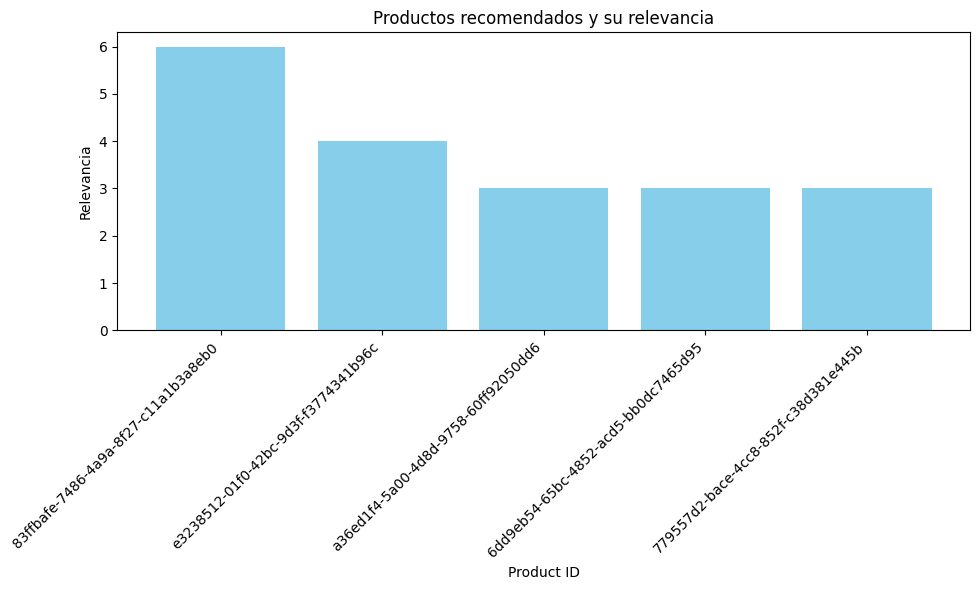

Evaluación del modelo:
Precisión: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [37]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix
import numpy as np

# Conexión a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]

# Cargar datos desde MongoDB
def load_data():
    customers = pd.DataFrame(list(db["customers"].find({}, {"Customer ID": 1, "First Name": 1, "_id": 0})))
    products = pd.DataFrame(list(db["products"].find({}, {"Product ID": 1, "General Category ID": 1, "_id": 0})))
    orders = pd.DataFrame(list(db["orders"].find({}, {"Customer ID": 1, "Product ID": 1, "_id": 0})))
    categories = pd.DataFrame(list(db["categories"].find({}, {"Category ID": 1, "Name": 1, "_id": 0})))
    return customers, products, orders, categories

# Crear matriz de interacciones usuario-categoría general
def create_interaction_matrix(customers, products, orders, categories):
    orders = orders.merge(products, on="Product ID", how="left")
    orders = orders.merge(categories, left_on="General Category ID", right_on="Category ID", how="left")
    interaction_matrix = orders.groupby(["Customer ID", "General Category ID"]).size().unstack(fill_value=0)
    return interaction_matrix, orders

def split_data(interaction_matrix, test_size=0.2):
    # Obtener los índices de los usuarios
    indices = np.arange(interaction_matrix.shape[0])
    
    # Dividir sin estratificación
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=42, shuffle=True
    )
    
    # Crear los conjuntos de entrenamiento y validación
    train_matrix = interaction_matrix.iloc[train_indices]
    test_matrix = interaction_matrix.iloc[test_indices]
    
    return train_matrix, test_matrix



# Entrenar un modelo de recomendación basado en categorías generales
def train_model(interaction_matrix):
    sparse_matrix = csr_matrix(interaction_matrix)
    user_similarity = cosine_similarity(sparse_matrix)
    similarity_df = pd.DataFrame(user_similarity, index=interaction_matrix.index, columns=interaction_matrix.index)
    return similarity_df

# Generar recomendaciones para un usuario
def recommend_products(user_id, interaction_matrix, similarity_df, orders, categories, top_n=5):
    if user_id not in interaction_matrix.index:
        return pd.DataFrame(columns=["Product ID", "Relevancia"])
    
    user_categories = interaction_matrix.loc[user_id]
    user_categories = user_categories[user_categories > 0].index.tolist()
    
    similar_users = similarity_df[user_id].sort_values(ascending=False).index.tolist()
    similar_users.remove(user_id)
    
    similar_orders = orders[orders["Customer ID"].isin(similar_users)]
    similar_orders = similar_orders[similar_orders["General Category ID"].isin(user_categories)]
    
    product_counts = similar_orders["Product ID"].value_counts().head(top_n)
    recommended_products = pd.DataFrame({
        "Product ID": product_counts.index,
        "Relevancia": product_counts.values
    })
    return recommended_products

# Evaluar el modelo
# Evaluar el modelo
def evaluate_model(test_matrix, train_matrix, similarity_df, orders, categories, top_n=5):
    y_true, y_pred = [], []
    
    # Usar únicamente usuarios que están en el conjunto de entrenamiento
    valid_users = test_matrix.index.intersection(train_matrix.index)
    
    for user_id in valid_users:
        user_interactions = test_matrix.loc[user_id]
        ground_truth = user_interactions[user_interactions > 0].index.tolist()
        
        recommendations = recommend_products(user_id, train_matrix, similarity_df, orders, categories, top_n)
        recommended_products = recommendations["Product ID"].tolist()
        
        # Depuración: imprimir recomendaciones y ground truth
        print(f"\nUsuario: {user_id}")
        print(f"Ground truth: {ground_truth}")
        print(f"Recomendaciones: {recommended_products}")
        
        y_true.extend([1 if category in ground_truth else 0 for category in test_matrix.columns])
        y_pred.extend([1 if category in recommended_products else 0 for category in test_matrix.columns])
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return precision, recall, f1


# Graficar recomendaciones
def plot_recommendations(recommended_products):
    plt.figure(figsize=(10, 6))
    plt.bar(recommended_products["Product ID"], recommended_products["Relevancia"], color='skyblue')
    plt.title("Productos recomendados y su relevancia")
    plt.xlabel("Product ID")
    plt.ylabel("Relevancia")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Flujo principal
def main():
    customers, products, orders, categories = load_data()
    interaction_matrix, enriched_orders = create_interaction_matrix(customers, products, orders, categories)
    train_matrix, test_matrix = split_data(interaction_matrix)
    similarity_df = train_model(train_matrix)
    
    user_id = train_matrix.index[0]
    recommendations = recommend_products(user_id, train_matrix, similarity_df, enriched_orders, categories)
    
    print(f"Recomendaciones para el usuario {user_id}:\n", recommendations)
    
    if not recommendations.empty:
        plot_recommendations(recommendations)
    
    precision, recall, f1 = evaluate_model(test_matrix, train_matrix, similarity_df, enriched_orders, categories)
    print(f"Evaluación del modelo:\nPrecisión: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}")

# Ejecutar flujo principal
if __name__ == "__main__":
    main()
